## CNN classification for brain hemorrahge

We have experimented with various models, including dense neural networks, simple CNNs, and ResNet50. Thus far, ResNet50 has demonstrated relatively better performance. Nevertheless, we will continue to explore different CNN architectures for hemorrhage classification.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import models, layers, utils, activations, losses, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks, Model
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50


#### Loading data

In [3]:
labels = pd.read_csv("/content/drive/MyDrive/CTScan/new_hemorrhage_label.csv")
labels.head(10)

,Image,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,normal
0,ID_48c9c3858.jpg,0,1,0,0,0,0
1,ID_79d8e9cd1.jpg,0,0,0,1,0,0
2,ID_6b2f0cf23.jpg,0,0,0,1,0,0
3,ID_2bcec32fd.jpg,0,1,0,0,0,0
4,ID_13a645629.jpg,0,1,0,0,0,0
5,ID_0084b7c8f.jpg,0,0,0,0,0,1
6,ID_142f03d16.jpg,0,0,1,0,0,0
7,ID_6a5356c79.jpg,0,0,0,1,0,0
8,ID_4b5de3a36.jpg,0,1,0,0,0,0
9,ID_5137f4b95.jpg,0,0,1,0,0,0


In [4]:
# Convert from one-hot encoding format to label encoding
hemorrhage_types = labels.drop(columns=['Image'])
hemorrhage_types = pd.get_dummies(hemorrhage_types).idxmax(1)
hemorrhage_types.head(10)

# Convert target y to label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(hemorrhage_types)

labels['y_encoded'] = y_encoded
labels.head(10)

,Image,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,normal,y_encoded
0,ID_48c9c3858.jpg,0,1,0,0,0,0,1
1,ID_79d8e9cd1.jpg,0,0,0,1,0,0,4
2,ID_6b2f0cf23.jpg,0,0,0,1,0,0,4
3,ID_2bcec32fd.jpg,0,1,0,0,0,0,1
4,ID_13a645629.jpg,0,1,0,0,0,0,1
5,ID_0084b7c8f.jpg,0,0,0,0,0,1,3
6,ID_142f03d16.jpg,0,0,1,0,0,0,2
7,ID_6a5356c79.jpg,0,0,0,1,0,0,4
8,ID_4b5de3a36.jpg,0,1,0,0,0,0,1
9,ID_5137f4b95.jpg,0,0,1,0,0,0,2


In [5]:
# Get the unique classes and their corresponding numerical labels
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Display the class mapping
print("Class Mapping:")
for class_name, label in class_mapping.items():
    print(f"{class_name}: {label}")

Class Mapping:
epidural: 0
intraparenchymal: 1
intraventricular: 2
normal: 3
subarachnoid: 4
subdural: 5


In [6]:
# Set the path to the image folder
img_path = '/content/drive/MyDrive/CTScan/shuffled_images'

# Create an empty list to store images
X = []

# Load and preprocess images
for file_name in labels.Image:
    image = cv2.imread(os.path.join(img_path, file_name))
    X.append(image)

X = np.array(X)


<ipython-input-6-b883260b7d42>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [7]:
X.shape, y_encoded.shape

((3446,), (3446,))

#### Check Brain CT images

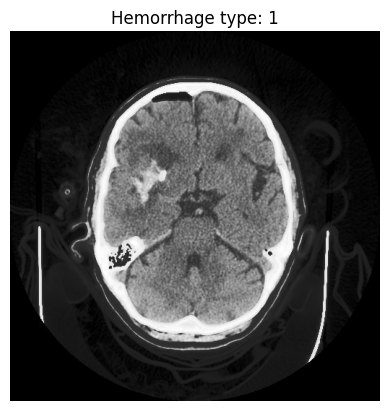

In [8]:
# Choose image's index
image_index = 8 # change any index that you're interested

# Display CT images
plt.imshow(X[image_index], cmap = 'gray')

# Set title as corresponding target y
title = f"Hemorrhage type: {y_encoded[image_index]}"

plt.title(title)
plt.axis('off')
plt.show()

In [9]:
label_counts = labels['y_encoded'].value_counts()
print(label_counts)
sum(label_counts)

1    953
2    534
3    500
4    498
5    490
0    471
Name: y_encoded, dtype: int64


3446

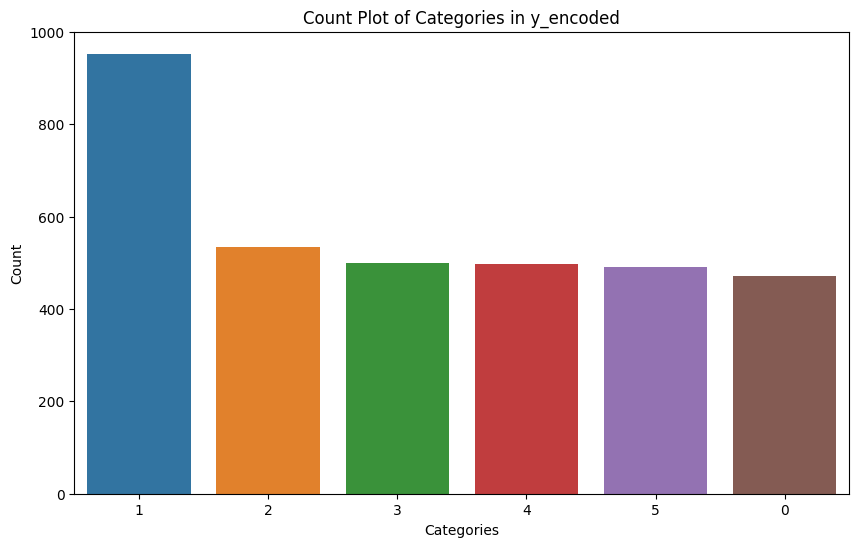

In [10]:
# Class distribution
label_counts = labels['y_encoded'].value_counts()

# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='y_encoded', data=labels, order=label_counts.index)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Count Plot of Categories in y_encoded')

# Show the plot
plt.show()

In [89]:
new_width = 32
new_height = 32

# Adjust the image size (if needed)
X = np.array([cv2.resize(img, (new_width, new_height)) for img in X])

# Split training/val/test data set
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [90]:
X_train.shape, y_train.shape

((2756, 32, 32, 3), (2756,))

In [13]:
# Get unique classes and their counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)
unique_classes, class_counts

(array([0, 1, 2, 3, 4, 5]), array([378, 768, 428, 405, 386, 391]))

As it's imbalanced data set, we employ over sampling to balance the class distribution.


### Oversampling (Resampling)
Oversample the minority classes to match the number of images in the majority class.

In [91]:
# Oversample the training set
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train) # RandomOverSampler expects a 2D array as input


In [15]:
X_train_resampled.shape, y_train_resampled.shape

((4608, 3072), (4608,))

In [92]:
# Reshape back to the original format
X_train_resampled_reshaped = X_train_resampled.reshape(X_train_resampled.shape[0], new_width, new_height, 3)

X_train_resampled_reshaped.shape, y_train_resampled.shape

((4608, 32, 32, 3), (4608,))

#### Image Augmenatation

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate between [-20, 20]
    width_shift_range=0.2,  # Randomly shift horizontally
    height_shift_range=0.2,  # Randomly shift vertically
    shear_range=0.2,  # Shear range
    zoom_range=0.2,  # Randomly zoom
    horizontal_flip=True,  # Randomly horizontal flip
    vertical_flip=True,  # Randomly vertical flip
    brightness_range=[0.8, 1.2]  # Randomly brightness
)

# Fit datagen to X_train
datagen.fit(X_train_resampled_reshaped)

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "brainCT_CNN_logs", "run_{:03d}".format(run_index))
run_logdir

'./brainCT_CNN_logs/run_001'

In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
)
checkpoint_cb = keras.callbacks.ModelCheckpoint("brainCT_CNN_20231231.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


### Fully connected neural network

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(6, activation="softmax")  # set up how many numbers of the final classification
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 300)               921900    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 6)                 606       
                                                                 
Total params: 952606 (3.63 MB)
Trainable params: 952606 (3.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(datagen.flow(X_train_resampled_reshaped, y_train_resampled, batch_size =32),
                    epochs =100,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
144/144 [==============================] - 4s 27ms/step - loss: 40.2726 - accuracy: 0.1630 - val_loss: 13.5745 - val_accuracy: 0.1768
Epoch 2/100
  4/144 [..............................] - ETA: 3s - loss: 15.4692 - accuracy: 0.1484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 4s 30ms/step - loss: 11.1681 - accuracy: 0.1701 - val_loss: 7.8420 - val_accuracy: 0.1304
Epoch 3/100
144/144 [==============================] - 4s 26ms/step - loss: 7.5616 - accuracy: 0.1691 - val_loss: 6.6415 - val_accuracy: 0.1855
Epoch 4/100
144/144 [==============================] - 4s 26ms/step - loss: 5.2981 - accuracy: 0.1699 - val_loss: 3.1141 - val_accuracy: 0.1594
Epoch 5/100
144/144 [==============================] - 5s 32ms/step - loss: 3.4464 - accuracy: 0.1693 - val_loss: 2.8377 - val_accuracy: 0.1855
Epoch 6/100
144/144 [==============================] - 4s 29ms/step - loss: 2.9019 - accuracy: 0.1780 - val_loss: 2.9504 - val_accuracy: 0.1391
Epoch 7/100
144/144 [==============================] - 4s 26ms/step - loss: 2.5462 - accuracy: 0.1753 - val_loss: 2.1265 - val_accuracy: 0.2435
Epoch 8/100
144/144 [==============================] - 5s 32ms/step - loss: 2.1613 - accuracy: 0.1884 - val_loss: 2.0228 - val_accuracy: 0.1768
Epo

#### Simple CNN

In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
# Simple CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))


In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [28]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
)
checkpoint_cb = keras.callbacks.ModelCheckpoint("brainCT_CNN_20231231.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [29]:
history = model.fit(datagen.flow(X_train_resampled_reshaped, y_train_resampled, batch_size =32),
                    epochs =100,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
144/144 [==============================] - 6s 38ms/step - loss: 4.8610 - accuracy: 0.1777 - val_loss: 1.8221 - val_accuracy: 0.2087
Epoch 2/100
144/144 [==============================] - 6s 43ms/step - loss: 1.8050 - accuracy: 0.1793 - val_loss: 1.7880 - val_accuracy: 0.2000
Epoch 3/100
144/144 [==============================] - 6s 44ms/step - loss: 1.7898 - accuracy: 0.1947 - val_loss: 1.7858 - val_accuracy: 0.2145
Epoch 4/100
144/144 [==============================] - 5s 36ms/step - loss: 1.7777 - accuracy: 0.2127 - val_loss: 1.7619 - val_accuracy: 0.2145
Epoch 5/100
144/144 [==============================] - 7s 46ms/step - loss: 1.7759 - accuracy: 0.2155 - val_loss: 1.7574 - val_accuracy: 0.2145
Epoch 6/100
144/144 [==============================] - 5s 37ms/step - loss: 1.7697 - accuracy: 0.2207 - val_loss: 1.8075 - val_accuracy: 0.2000
Epoch 7/100
144/144 [==============================] - 6s 43ms/step - loss: 1.7609 - accuracy: 0.2316 - val_loss: 1.7403 - val_accuracy:

In [31]:
# Predict y
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Compute and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


11/11 [==============================] - 0s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.35      0.15      0.21        92
           2       0.24      0.70      0.36        46
           3       0.42      0.44      0.43        52
           4       0.16      0.06      0.09        62
           5       0.18      0.34      0.24        50

    accuracy                           0.26       345
   macro avg       0.23      0.28      0.22       345
weighted avg       0.24      0.26      0.22       345

Confusion Matrix:
[[ 0  7 12  8  4 12]
 [ 0 14 39  9  4 26]
 [ 0  3 32  3  1  7]
 [ 0  3 10 23  2 14]
 [ 0  7 25  9  4 17]
 [ 0  6 14  3 10 17]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


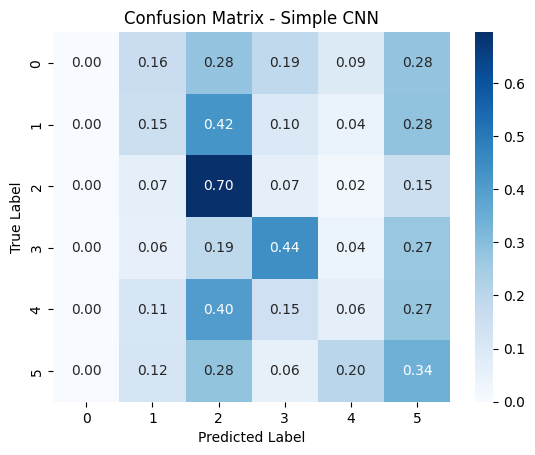

In [34]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Simple CNN")
plt.show()

### ResNet50

In [35]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
# Transfer learning: ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 [==============================] - 1s 0us/step


In [37]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
)


In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [39]:
history = model.fit(datagen.flow(X_train_resampled_reshaped, y_train_resampled, batch_size =32),
                    epochs =100,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
144/144 [==============================] - 19s 112ms/step - loss: 2.4433 - accuracy: 0.2441 - val_loss: 1.7011 - val_accuracy: 0.3188
Epoch 2/100
144/144 [==============================] - 17s 120ms/step - loss: 1.7151 - accuracy: 0.2754 - val_loss: 1.6783 - val_accuracy: 0.2899
Epoch 3/100
144/144 [==============================] - 16s 108ms/step - loss: 1.6723 - accuracy: 0.2954 - val_loss: 1.7275 - val_accuracy: 0.2493
Epoch 4/100
144/144 [==============================] - 16s 108ms/step - loss: 1.6746 - accuracy: 0.2925 - val_loss: 1.6988 - val_accuracy: 0.2377
Epoch 5/100
144/144 [==============================] - 17s 117ms/step - loss: 1.6487 - accuracy: 0.3062 - val_loss: 1.6747 - val_accuracy: 0.2696
Epoch 6/100
144/144 [==============================] - 18s 123ms/step - loss: 1.6446 - accuracy: 0.3049 - val_loss: 1.6564 - val_accuracy: 0.3246
Epoch 7/100
144/144 [==============================] - 15s 105ms/step - loss: 1.6386 - accuracy: 0.3071 - val_loss: 1.6549 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 16s 111ms/step - loss: 1.6389 - accuracy: 0.3060 - val_loss: 1.6304 - val_accuracy: 0.3420
Epoch 9/100
144/144 [==============================] - 16s 108ms/step - loss: 1.6398 - accuracy: 0.3097 - val_loss: 1.6644 - val_accuracy: 0.3449
Epoch 10/100
144/144 [==============================] - 18s 123ms/step - loss: 1.6328 - accuracy: 0.3116 - val_loss: 1.6413 - val_accuracy: 0.3159
Epoch 11/100
144/144 [==============================] - 15s 105ms/step - loss: 1.6313 - accuracy: 0.3075 - val_loss: 1.7076 - val_accuracy: 0.2812
Epoch 12/100
144/144 [==============================] - 16s 108ms/step - loss: 1.6378 - accuracy: 0.3069 - val_loss: 1.6419 - val_accuracy: 0.3362
Epoch 13/100
144/144 [==============================] - 15s 107ms/step - loss: 1.6233 - accuracy: 0.3227 - val_loss: 1.6592 - val_accuracy: 0.3101
Epoch 14/100
144/144 [==============================] - 16s 113ms/step - loss: 1.6230 - accuracy: 0.3184 - val_loss: 1.6286 - val_ac

In [43]:
# Predict y from the Model ResNet50
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Compute and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix_res50 = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_res50)

11/11 [==============================] - 1s 104ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.07      0.07        43
           1       0.35      0.25      0.29        92
           2       0.27      0.41      0.32        46
           3       0.49      0.33      0.39        52
           4       0.39      0.18      0.24        62
           5       0.22      0.48      0.30        50

    accuracy                           0.28       345
   macro avg       0.30      0.29      0.27       345
weighted avg       0.32      0.28      0.28       345

Confusion Matrix:
[[ 3  9  7  4  1 19]
 [ 6 23 23  3  6 31]
 [ 6 12 19  3  3  3]
 [10  1  6 17  5 13]
 [ 7 10  9  6 11 19]
 [ 5 10  7  2  2 24]]


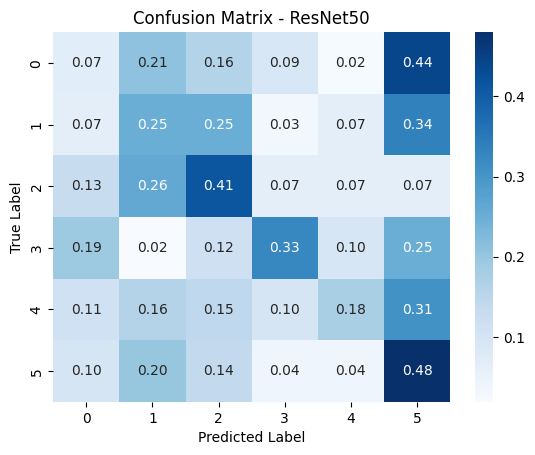

In [44]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_res50.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet50")
plt.show()

### Customized CNN

Let's go through each part:

1. **Convolutional Layers:**
- The first Conv2D layer with 32 filters and a small filter size (3x3) is used to capture low-level features in the input images. The activation function is ReLU, which introduces non-linearity to the model.
- The first `MaxPooling2D` layer follows to downsample the spatial dimensions and reduce computational complexity. It captures the most important information from the previous convolutional layer.
- Similar patterns are repeated with additional convolutional and max pooling layers. The number of filters generally increases, allowing the model to learn more complex and abstract features as it progresses through the layers.

2. **Flatten Layer:**
- The `Flatten` layer is used to flatten the 3D output to 1D before feeding it into the dense layers. This is necessary because the subsequent layers expect a one-dimensional input.

3. **Dense Layers:**
- The first Dense layer with 256 neurons and ReLU activation is a fully connected layer that combines the extracted features. This layer serves as a bridge between the convolutional layers and the output layer.
- The Dropout(0.5) layer is introduced to reduce overfitting by randomly setting a fraction of input units to zero during training. This helps prevent the model from relying too much on specific neurons and encourages more robust learning.

4. **Output Layer:**
The final Dense layer with num_classes neurons and softmax activation produces the output probabilities for each class in your classification task.


In [46]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
## Design CNN
from keras.layers import Dropout


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))


In [50]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 2, 2, 128)        

In [51]:
history = model.fit(datagen.flow(X_train_resampled_reshaped, y_train_resampled, batch_size =32),
                    epochs =100,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
144/144 [==============================] - 8s 46ms/step - loss: 3.2862 - accuracy: 0.1730 - val_loss: 1.7875 - val_accuracy: 0.1826
Epoch 2/100
144/144 [==============================] - 7s 46ms/step - loss: 1.7866 - accuracy: 0.1866 - val_loss: 1.7874 - val_accuracy: 0.1710
Epoch 3/100
144/144 [==============================] - 6s 39ms/step - loss: 1.7887 - accuracy: 0.1897 - val_loss: 1.7770 - val_accuracy: 0.2145
Epoch 4/100
144/144 [==============================] - 6s 39ms/step - loss: 1.7695 - accuracy: 0.2203 - val_loss: 1.7530 - val_accuracy: 0.2435
Epoch 5/100
144/144 [==============================] - 7s 47ms/step - loss: 1.7750 - accuracy: 0.2094 - val_loss: 1.7881 - val_accuracy: 0.1913
Epoch 6/100
144/144 [==============================] - 6s 41ms/step - loss: 1.7507 - accuracy: 0.2326 - val_loss: 1.7564 - val_accuracy: 0.2232
Epoch 7/100
144/144 [==============================] - 7s 45ms/step - loss: 1.7475 - accuracy: 0.2296 - val_loss: 1.7526 - val_accuracy:

In [52]:
# Predict y from the model customized CNN
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Compute and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


11/11 [==============================] - 0s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.34      0.29      0.31        92
           2       0.18      0.76      0.29        46
           3       0.42      0.50      0.46        52
           4       0.44      0.06      0.11        62
           5       0.00      0.00      0.00        50

    accuracy                           0.27       345
   macro avg       0.23      0.27      0.20       345
weighted avg       0.26      0.27      0.21       345

Confusion Matrix:
[[ 0 14 24  5  0  0]
 [ 0 27 55  9  1  0]
 [ 0  4 35  7  0  0]
 [ 1  6 14 26  4  1]
 [ 0 19 27 12  4  0]
 [ 0 10 37  3  0  0]]


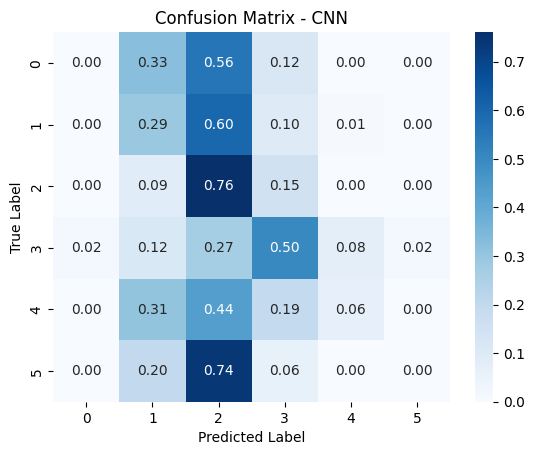

In [54]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN")
plt.show()

In [45]:
# Get unique classes and their counts
unique_classes, class_counts = np.unique(y_test, return_counts=True)
unique_classes, class_counts

(array([0, 1, 2, 3, 4, 5]), array([43, 92, 46, 52, 62, 50]))